In [1]:
import os
import requests
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field 
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from API.booking import BookingAPI
from API.geoCoding import GeoCodingAPI
from API.getKey import OAuthClient
from API.getQuotes import QuotesAPI
from API.is_Airport import IsAirport

llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'

class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride.This is optional if provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user.This is optional if provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name.This is optional if provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name.This is optional if provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time..This is optional if provided"
    )
    # @feild_validator('')


def check_what_is_empty(user_personal_details):
    ask_for = []
    # Check if fields are empty
    for field, value in user_personal_details.model_dump().items():
        if value in [None, "", 0]:  # Add other 'empty' conditions if needed
            print(f"Field '{field}' is empty.")
            ask_for.append(field)
    return ask_for

def add_non_empty_details(current_details: BookingCarDetails, new_details: BookingCarDetails):
    non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=non_empty_details)
    return updated_details

def ask_for_info(ask_list: list):
    first_prompt = ChatPromptTemplate.from_template(
        """Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help. If 'ask_for' is empty, thank the user and ask how you can assist next.
        ### ask_for list: {ask_for}"""
    )
    info_gathering_chain = first_prompt | llm | StrOutputParser()
    ai_chat = info_gathering_chain.invoke({"ask_for": ask_list})
    print(first_prompt)
    return ai_chat
def filter_response(text_input, user_details ):
    chain = llm.with_structured_output(BookingCarDetails)
    res = chain.invoke(text_input)
    # add filtered info to the
    user_details = add_non_empty_details(user_details,res)
    print(user_details)
    ask_for = check_what_is_empty(user_details)
    return user_details, ask_for
def ask_confirm_info(booking_details: BookingCarDetails):
    # booking_details.
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)
@tool
def get_booking_details(input_text):
    """ This is function to get information for booking"""
    chain = llm.with_structured_output(BookingCarDetails)
    # response_text = "i want to book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow "
    response = chain.invoke(input_text)
    booking_details = BookingCarDetails(
        name="", number_phone="", pick_up_location="", destination_location="", pick_up_time=""
    )
    booking_details = add_non_empty_details(booking_details, response)
    ask_for = check_what_is_empty(booking_details)
    ai_response = ask_for_info(ask_for)
    print(ai_response)
    text_input = input()
    user_details, ask_for = filter_response(text_input, booking_details)
    while ask_for:  
        ai_response = ask_for_info(ask_for)
        input
        print(ai_response)
        text_input = input()
        user_details, ask_for = filter_response(text_input, user_details)
        print(ask_for)
    
    ask_confirm_info(user_details)
    return user_details


In [2]:
@tool
def get_quotes(booking_details : BookingCarDetails):
    """This function to get quotes for bookings"""
    quotesAPI = QuotesAPI(os.getenv("JUPITER_API") + "/demand/v1/quotes")
    geoCodingAPI = GeoCodingAPI()
    # geoCoding_destination =
    geoCoding_pickup =  geoCodingAPI.get_geocoding(booking_details.pick_up_location)
    geoCoding_destination = geoCodingAPI.get_geocoding(booking_details.destination_location)
    
    # input_datetime = datetime.fromisoformat(pick_up_time)
    pickup_datetime = "2025-01-18T09:24:10.000Z"
    
    pickup_coords = { "latitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lng']),}
    destination_coords = { "latitude": float(geoCoding_destination['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_destination['results'][0]['geometry']['location']['lng']),}
    quotes_data = quotesAPI.get_quotes(pickup_datetime, pickup_coords, destination_coords)
    return quotes_data

In [4]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END

In [ ]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [29]:
@tool
def confirm(state: MessagesState, booking_details : BookingCarDetails):
    """This function ask user to confirm information booking """
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)
    return 

In [40]:
workflow = StateGraph(MessagesState)
tools = [get_booking_details]   
tool_getinfo = ToolNode(tools)

tool_confirm = ToolNode([confirm])

tool_getquotes = ToolNode([get_quotes])

workflow.add_node("agent", call_model)
workflow.add_node("get_info", tool_getinfo)
workflow.add_node("confirm",tool_confirm)
workflow.add_node("get_quotes",tool_getquotes)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "get_info")
workflow.add_conditional_edges("get_info", should_continue, ["confirm"])
workflow.add_edge("confirm", "get_quotes")
# workflow.add_edge("get_info", "agent")
app = workflow.compile()

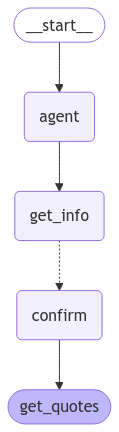

In [41]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")